Run cells in the following notebook to save off dataframe before running this notebook: `~/code/ontogeny/notebooks/exploration/win/old-age-cleanup/2023-09-01-cleanup-old-age.ipynb`

Also uses the `processing/figure-data` notebook for fig 1

In [31]:
import joblib
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from aging.behavior.scalars import compute_scalars
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, ONTOGENY_AGE_CMAP

In [2]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "network-optim", tight_layout=False)

## Extract dynamics

In [3]:
data = joblib.load("/n/scratch3/users/w/wg41/aging-aligned-frames.p")

In [4]:
list(data)

['frames', 'recon']

In [5]:
win_size = 40 * 30

agg_corrs = []
agg_rolling_corrs = []

for (*args, age), frames in tqdm(data["frames"].items()):
    # compute scalars
    scalars = compute_scalars(frames, is_recon=False, height_thresh=10)
    recon_scalars = compute_scalars(
        data["recon"][(*args, age)], is_recon=False, height_thresh=10
    )

    # compute correlations
    tmp_corrs = {}
    for k, v in scalars.items():
        tmp_corrs[k] = pd.Series(v).corr(pd.Series(recon_scalars[k]))
    tmp_corrs["avg"] = np.mean(list(tmp_corrs.values()))
    tmp_corrs["age"] = age
    agg_corrs.append(tmp_corrs)

    # compute rolling correlations
    rolling_corrs = {}
    for k, v in scalars.items():
        pl_df = pl.DataFrame({k: v, f"{k}_recon": recon_scalars[k]})
        corr_val = pl_df.with_columns(
            [pl.rolling_corr(k, f"{k}_recon", window_size=win_size).alias("corr")]
        )["corr"]
        rolling_corrs[k] = np.asarray(corr_val)
    rolling_corrs = pd.DataFrame(rolling_corrs)
    rolling_corrs["avg"] = rolling_corrs.mean(1)
    rolling_corrs["age"] = age
    for name, val in zip(["idx", "uuid", "path"], args):
        rolling_corrs[name] = val
    agg_rolling_corrs.append(rolling_corrs)

  0%|          | 0/110 [00:00<?, ?it/s]

In [6]:
cdf = pd.DataFrame(agg_corrs)

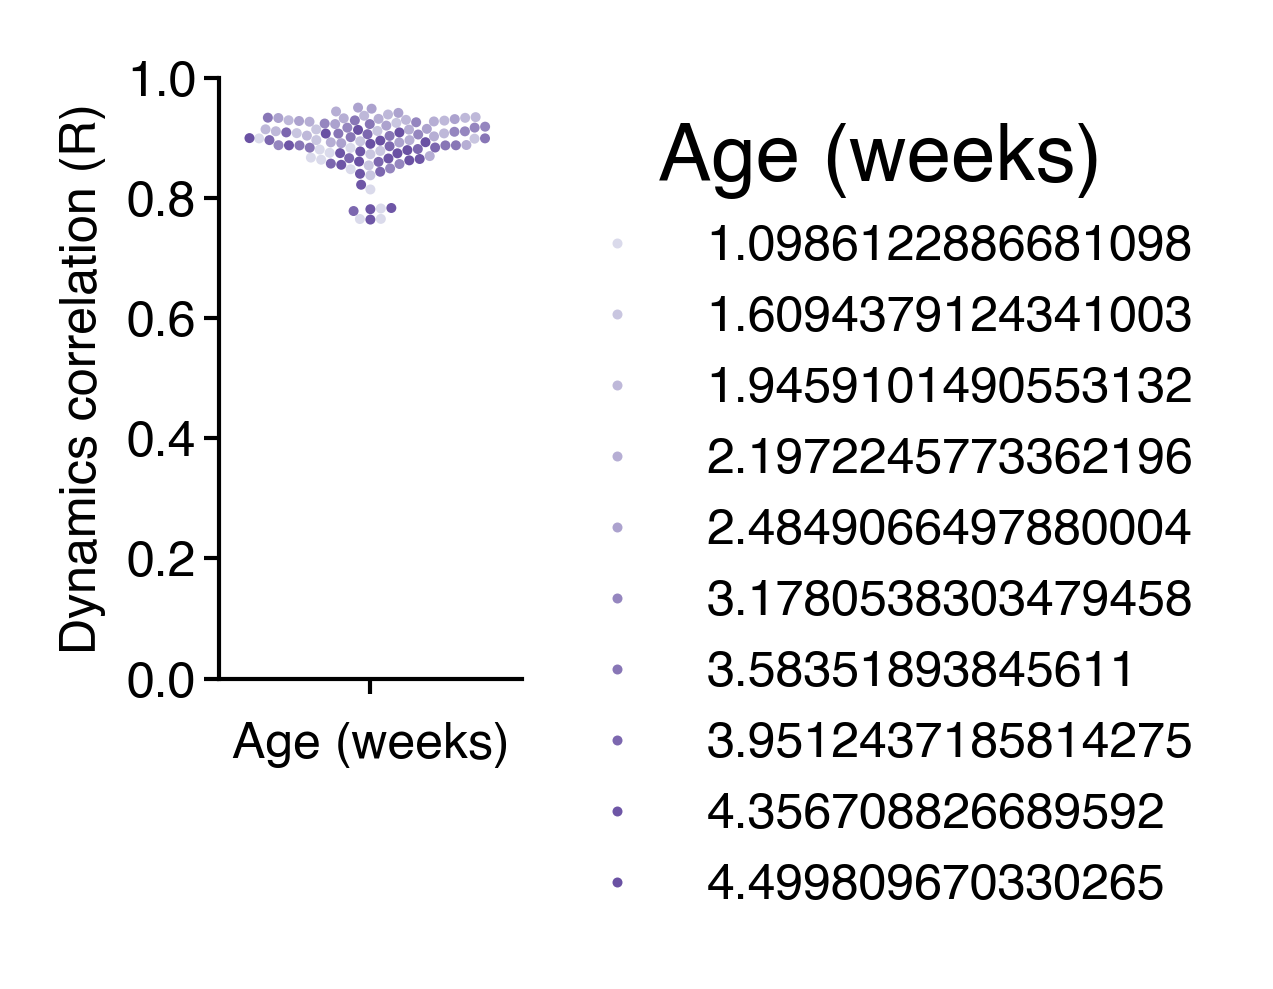

In [81]:
fig = figure(0.65, 1.3)
cdf["log_age"] = np.log(cdf["age"])
ax = sns.swarmplot(
    data=cdf,
    y="avg",
    hue="log_age",
    palette=ONTOGENY_AGE_CMAP,
    size=1.2,
    legend="full",
)
ax.set(ylim=(0, 1), xlabel="Age (weeks)", ylabel="Dynamics correlation (R)")
legend(ax, title="Age (weeks)")
sns.despine()
saver(fig, "dynamics-correlation-vs-log_age-swarmplot");

## Individual examples

In [35]:
def zscore(arr):
    return (arr - np.nanmean(arr)) / np.nanstd(arr)

In [8]:
r_corr_df = pd.concat(agg_rolling_corrs, ignore_index=True)

In [10]:
r_corr_df

,width,length,height,area,avg,age,idx,uuid,path
0,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
1,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
2,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
3,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
4,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
...,...,...,...,...,...,...,...,...,...
1374995,0.946882,0.974716,0.964447,0.925839,0.952971,90,141,b878ffa4-ab8b-42bb-821a-f8bb23af1959,/n/groups/datta/win/longtogeny/data/ontogeny/v...
1374996,0.947230,0.974825,0.964387,0.925743,0.953046,90,141,b878ffa4-ab8b-42bb-821a-f8bb23af1959,/n/groups/datta/win/longtogeny/data/ontogeny/v...
1374997,0.947381,0.974853,0.964329,0.925693,0.953064,90,141,b878ffa4-ab8b-42bb-821a-f8bb23af1959,/n/groups/datta/win/longtogeny/data/ontogeny/v...
1374998,0.947434,0.974874,0.964278,0.925596,0.953046,90,141,b878ffa4-ab8b-42bb-821a-f8bb23af1959,/n/groups/datta/win/longtogeny/data/ontogeny/v...


In [11]:
for (age, uuid), _df in r_corr_df.groupby(['age', 'uuid'], sort=False):
    break

In [12]:
_df

,width,length,height,area,avg,age,idx,uuid,path
0,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
1,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
2,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
3,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
4,NaN,NaN,NaN,NaN,NaN,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
...,...,...,...,...,...,...,...,...,...
12495,NaN,NaN,NaN,0.526486,0.526486,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
12496,NaN,NaN,NaN,0.526371,0.526371,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
12497,NaN,NaN,NaN,0.526207,0.526207,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...
12498,NaN,NaN,NaN,0.525470,0.525470,3,90,56ce96a5-cfa2-48ea-b4ff-7190b18bb5e7,/n/groups/datta/win/longtogeny/data/ontogeny/v...


In [18]:
best_young_uuid = r_corr_df.query('age == 3').groupby('uuid')['width'].max().idxmax()

In [19]:
best_young_uuid

'2b5a857f-2e64-470c-801e-1149450c6f56'

In [75]:
young_df = r_corr_df.query('uuid == @best_young_uuid')
end_idx = np.argmax(young_df['width'])

key = tuple(young_df.iloc[0][['idx', 'uuid', 'path', 'age']])

start = end_idx - win_size
scalars = compute_scalars(data['frames'][key], is_recon=False, height_thresh=10)
recon_scalars = compute_scalars(
    data["recon"][key], is_recon=False, height_thresh=10
)
w1 = zscore(scalars['width'][start:end_idx])
w2 = zscore(recon_scalars['width'][start:end_idx])
time = np.arange(win_size) / 30

w1 = pd.Series(w1).rolling(8).mean()
w2 = pd.Series(w2).rolling(8).mean()

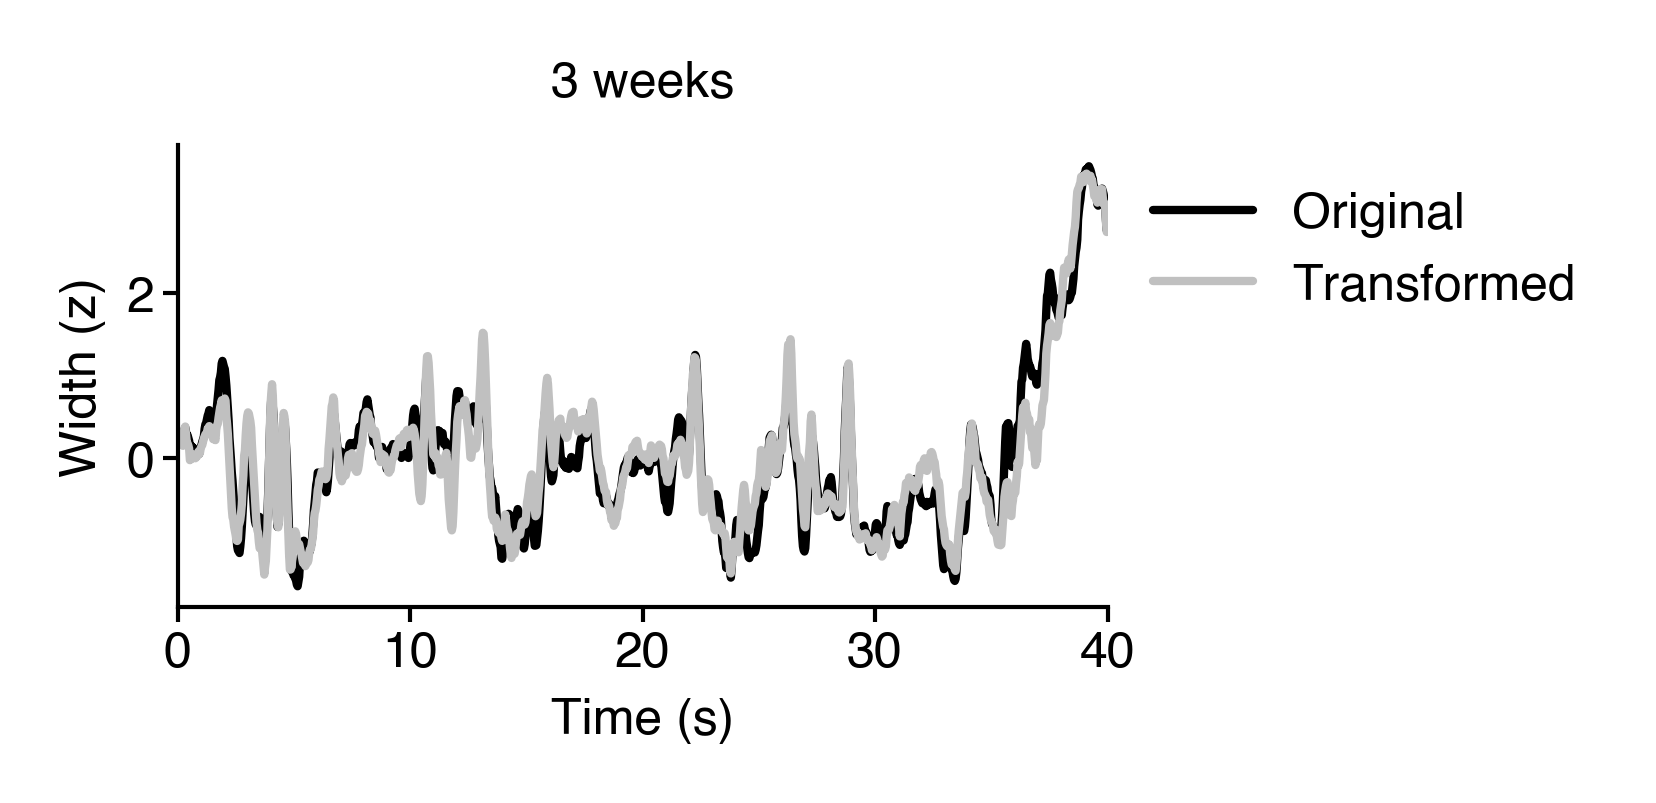

In [76]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label='Original', color='k')
ax.plot(time, w2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (z)", title='3 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-3-wks');

In [77]:
best_old_uuid = r_corr_df.query('age == 52').groupby('uuid')['width'].max().idxmax()

old_df = r_corr_df.query('uuid == @best_old_uuid')
end_idx = np.argmax(old_df['width'])

key = tuple(old_df.iloc[0][['idx', 'uuid', 'path', 'age']])

start = end_idx - win_size
scalars = compute_scalars(data['frames'][key], is_recon=False, height_thresh=10)
recon_scalars = compute_scalars(
    data["recon"][key], is_recon=False, height_thresh=10
)
w1 = zscore(scalars['width'][start:end_idx])
w2 = zscore(recon_scalars['width'][start:end_idx])
time = np.arange(win_size) / 30


w1 = pd.Series(w1).rolling(8).mean()
w2 = pd.Series(w2).rolling(8).mean()

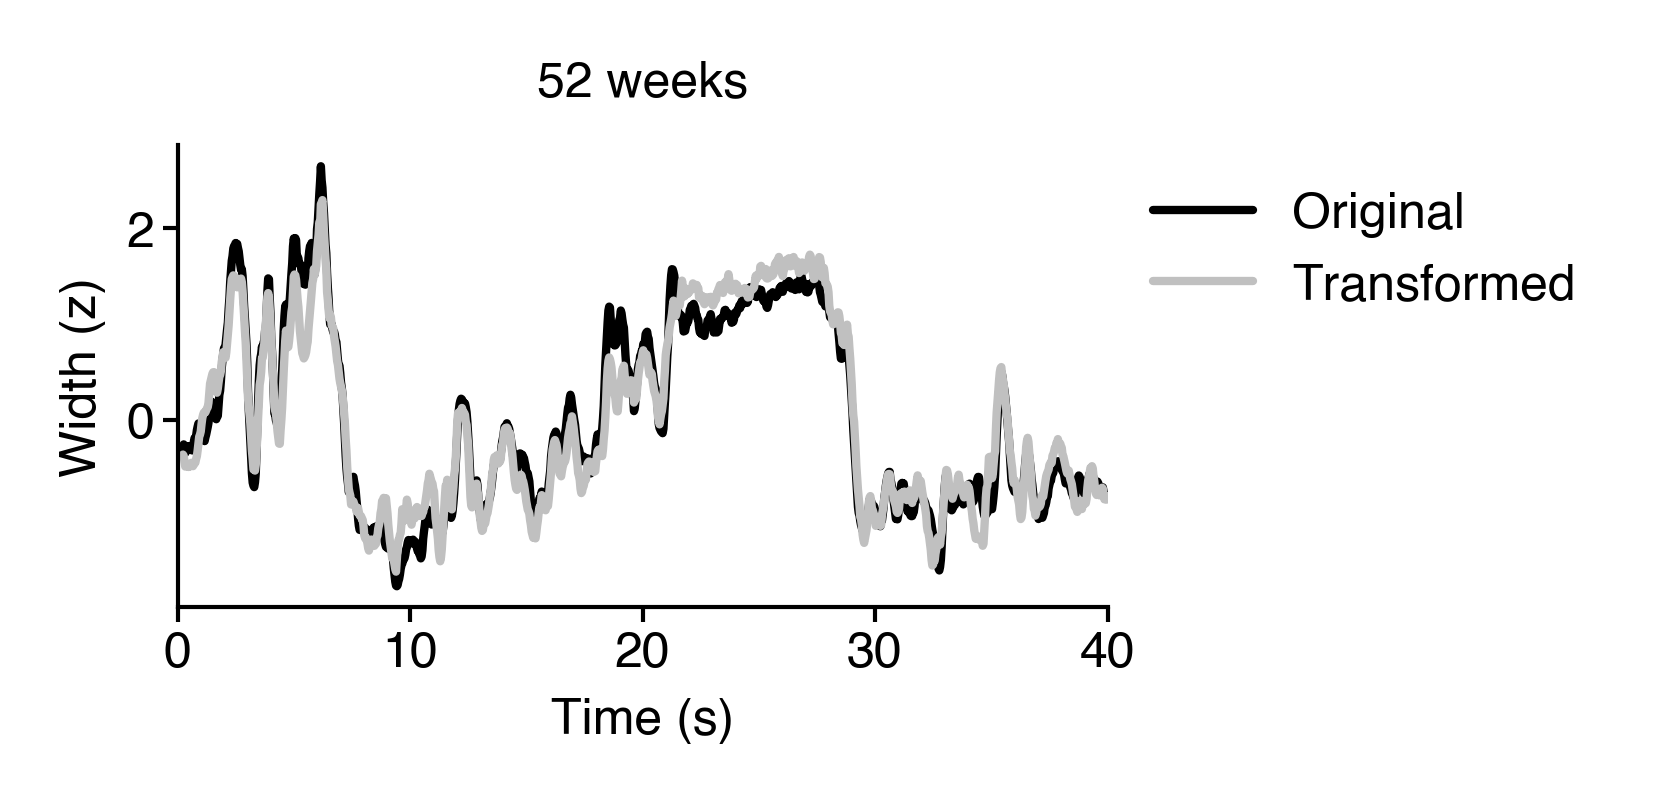

In [78]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label='Original', color='k')
ax.plot(time, w2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (z)", title='52 weeks', xlim=(0, 40)) 
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-52-wks');

In [79]:
best_old_uuid = r_corr_df.query('age == 78').groupby('uuid')['width'].max().idxmax()

old_df = r_corr_df.query('uuid == @best_old_uuid')
end_idx = np.argmax(old_df['width'])

key = tuple(old_df.iloc[0][['idx', 'uuid', 'path', 'age']])

start = end_idx - win_size
scalars = compute_scalars(data['frames'][key], is_recon=False, height_thresh=10)
recon_scalars = compute_scalars(
    data["recon"][key], is_recon=False, height_thresh=10
)
w1 = zscore(scalars['width'][start:end_idx])
w2 = zscore(recon_scalars['width'][start:end_idx])
time = np.arange(win_size) / 30


w1 = pd.Series(w1).rolling(8).mean()
w2 = pd.Series(w2).rolling(8).mean()

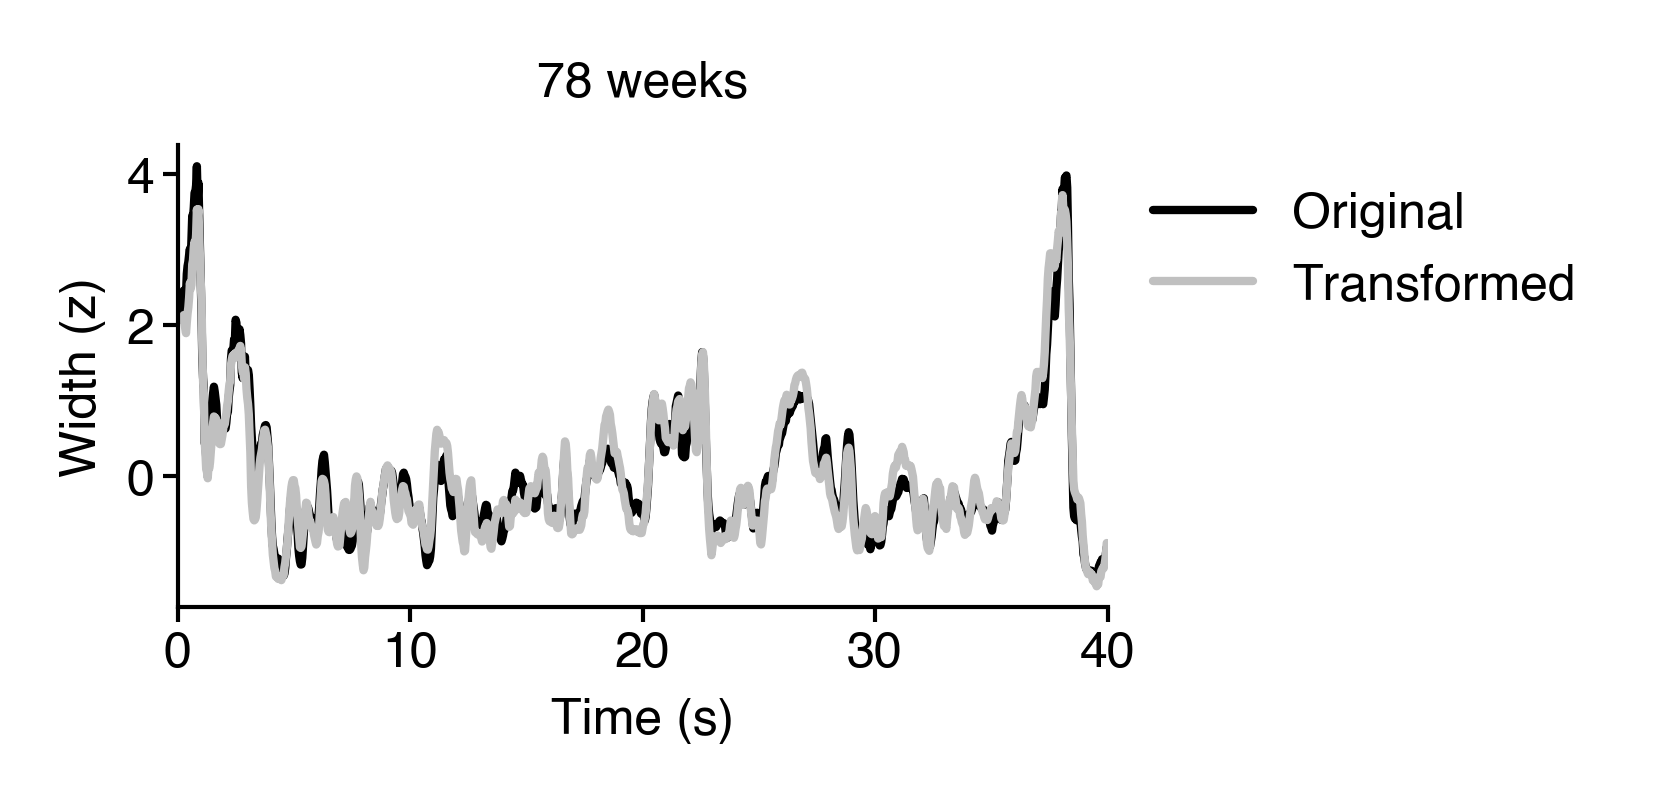

In [80]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label='Original', color='k')
ax.plot(time, w2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (z)", title='78 weeks', xlim=(0, 40)) 
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-78-wks');